# [Project 1 - CMSC320](https://github.com/cmsc320/fall2022/tree/main/project1)

by Joshua Ng 119386187

Posted: September 18, 2022; Due: October 1, 2022

Please read the entire document before starting!

You've been hired by a new space weather startup looking to disrupt the space weather reporting business. Your first project is to provide better data about the top 50 solar flares recorded so far than that shown by your swl SpaceWeatherLive.com. To do this, they've pointed you to this messy HTML page from NASA ((that link is just a copy of this real NASA page but we don't want to DDoS NASA)) where you can get the extra data your startup is going to post in your new spiffy site.

Of course, you don't have access to the raw data for either of these two tables, so as an enterprising data scientist you will scrape this information directly from each HTML page using all the great tools available to you in Python. By the way, you should read up a bit on Solar Flares, coronal mass ejections, the solar flare alphabet soup, the scary storms of Halloween 2003, and sickening solar flares.

## Part 1: Data scraping and preparation

### Step 1: Scrape your swl's data (10 pts)

In [117]:
import requests, pandas as pd, numpy as np, datetime, re
from bs4 import BeautifulSoup

In [118]:
dfs = pd.read_html(io = "https://cmsc320.github.io/files/top-50-solar-flares.html")

In [119]:
# get the data frame and rename the columns
swl_df = dfs[0]
swl_df.columns = ["rank","flare_classification", "date", "region", "start_time", "maximum_time","end_time", "drop"]

### Step 2: Tidy the top 50 solar flare data (10 pts)

In [120]:
# drop the last column
swl_df= swl_df.drop(labels="drop", axis = 1)


In [121]:
# combine the date and time for start, max and end time
for rank, row in swl_df.iterrows():
    col = ["start_time", "maximum_time", "end_time"]
    for c in col:
        dt =row["date"].split("/")
        tm = row[c].split(":")
        dt_f = datetime.datetime(*[int(i) for i in dt])
        tm_f = datetime.time(*[int(i) for i in tm])
        swl_df.at[rank,c] = dt_f.combine(dt_f, tm_f)
    # clean flare_classification
    x = swl_df.at[rank, "flare_classification"]
    if "+" in x:
        swl_df.at[rank, "flare_classification"] = x[:-1]
    # clean region
    r = swl_df.at[rank,"region"]
    if r == "-":
        swl_df.at[rank,"region"] = 0    

In [122]:
# save the df with date for later
swl_int_df = swl_df
swl_int_df.to_csv("swl_int_df.csv")
# we no longer need the date, lets drop that column
swl_df = swl_df.drop(columns="date", axis = 1)

In [123]:
# rename the headers
swl_df.columns = ["rank","flare_classification", "region", "start_datetime", "max_datetime","end_datetime"]

### Step 3: Scrape the NASA data (15 pts)

In [124]:
nasaPage = requests.get( "https://cmsc320.github.io/files/waves_type2.html")
with open("nasa.html", 'wb+')as f:
    f.write(nasaPage.content)
f.close()
with open("nasa.html", 'r') as f:
    nasaSoup = BeautifulSoup(f.read(), 'html.parser')

In [125]:
for a_tag in nasaSoup("a"):
    a_tag.unwrap()
# print(nasaSoup.text)
with open("nasaDropA.html", "w") as f:
    f.write(str(nasaSoup.text))

### Step 4: Tidy the NASA the table (15 pts)

In [126]:
from cmath import nan

with open("nasaDropA.html", 'r') as f:
    lines = list(f)
# for i in range(12):
#     print(lines[i])
headers = ["start_date", "start_time", "end_date", "end_time", "start_frequency", "end_frequency", "flare_location", "flare_region","flare_classification", "cme_date", "cme_time", "cme_angle", "cme_width","cme_speed"]
# process as 2D array+
matrix = []
for i in range(15, 533):
    line = lines[i].split()[:14]
    leng = len(line)
    for i in range(leng):
        if "-" in line[i]:
            line[i] = float(nan)
        elif "?" in line[i]:
            line[i] = float(nan)
    matrix.append(line)

In [127]:
# moving into pandas dataframe
nasa_df = pd.DataFrame(matrix, columns=headers)
nasa_df["isHalo"] = nasa_df.apply(lambda row: row.cme_angle == "Halo", axis = 1)
def f(s):
    return ">" in str(s)
nasa_df["width_lower_bound"] = nasa_df.apply(lambda row: f(row.cme_width), axis = 1)

In [128]:
# merging date and time
for rank, row in nasa_df.iterrows():
    col = ["start_time", "end_time"]

    for c in col:
        add = False
        pre = c.replace("_time", "_date")
        dt =row[pre].split("/")
        # time
        if c == "start_time":
            year = int(dt[0])
            # print(year)
        tm = row[c]
        # clean dirty timings
        if "24:" in tm:
            tm = tm.replace("24:", "00:")
            add = True
        tm = tm.split(":")

        # date

        if "end" in c:
             dt_f = datetime.datetime(year, *[int(i) for i in dt])
        else:
            dt_f = datetime.datetime(*[int(i) for i in dt])
        if add:
            dt_f += datetime.timedelta(days = 1)
        
        tm_f = datetime.time(*[int(i) for i in tm])
        nasa_df.at[rank,c] = dt_f.combine(dt_f, tm_f)

In [129]:
# edit angle
nasa_df["cme_angle"] = nasa_df["cme_angle"].replace("Halo", float(nan))
# edit width
nasa_df["cme_width"] = nasa_df["cme_width"].str.replace(">", "")

#save a copy of nasa_df with date preserved for Q2
nasa_i_df = nasa_df.copy()
# nasa_i_df.rename(columns={"start_date":"date"}, inplace=True)
nasa_i_df.to_csv("nasa_i.csv")
nasa_df.drop(["start_date", "end_date"], axis = 1, inplace = True)
# rename datetime columns
nasa_df.rename(columns={'start_time':'start_datetime', 'end_time':'end_datetime'}, inplace=True)


# save a copy of nasa_df
nasa_df.to_csv("nasa_df.csv")

## Part 2: Analysis

### Q1: Replication
Find top 50 by classification in NASA data.



In [130]:
nasa_r_df = nasa_df.loc[nasa_df['flare_classification'].str.contains("X", na=False)].copy() # since everything in SWL data is X class, filter NASA data for X class
nasa_r_df["flare_classification"] = nasa_r_df["flare_classification"].str.replace("X", "") # clean out the X so we can order it
nasa_r_df["flare_classification"] = nasa_r_df["flare_classification"].astype(float) # change from string to float so numbers with decimal point are ordered properly
nasa_r_df.sort_values(by=['flare_classification'], ascending=False, inplace =True ) # sort 
nasa_r_df.to_csv("nasa_r.csv") # save to csv all rows
nasa_r_df.head(50).to_csv("nasa_r_50.csv") # save only the top 50

### Q1 Findings:

There are some discrepancies - corrupted data and missing data. Compare "nasa_r.csv" to "swl_int.csv"

1. Corrupted data: 

    Entry # 3, 4 (SWL), X17.2 and X17 exist in SWL data, but only X17.2 exists in NASA data... and a X1.7 with a date that maps to the X17 solar flare in SWL's data! The decimal point has shifted on one of these entries.

2. Missing data:  

    Entry #16 (SWL), an X6.2 solar flare on 2001/12/13 exists in SWL data, but is missing in NASA's data.

Conclusion:

These are just a few examples of the types of problems that persist throughout SWL's top 50 entries, so I cannot replicate SWL data fully with NASA data as I don't know which source of data is more authoritative.

### Q2: Integration
Find the rows in NASA data that best match with SWL data (top 50). Since most solar flares don't occur on the same day, I'll try to match by start date to the  

However, NASA's data shows 466 unique start dates out of 518, so there might be some overlap within the top 50. 

In [131]:
swl_df = swl_df.loc[swl_df['flare_classification'].str.contains("X", na=False)].copy() # since everything in SWL data is X class, filter NASA data for X class
swl_df["flare_classification"] = swl_df["flare_classification"].str.replace("X", "") # clean out the X so we can order it
swl_df["flare_classification"] = swl_df["flare_classification"].astype(float)
swl_df.to_csv("swl.csv")

In [132]:
# "by" column must be in string format, "on" columns must both be numeric type (datetime)

swl_df["flare_classification"] = swl_df["flare_classification"].astype(str) 
nasa_r_df["flare_classification"] = nasa_r_df["flare_classification"].astype(str)
swl_df["start_datetime"] = pd.to_datetime(swl_df["start_datetime"])
nasa_r_df["start_datetime"] = pd.to_datetime(nasa_r_df["start_datetime"])

In [133]:
# Left join on nasa_table
result = pd.merge_asof(nasa_r_df.sort_values("start_datetime"),swl_df.sort_values("start_datetime"),  by= "flare_classification", on= "start_datetime", tolerance=pd.Timedelta('2h'))
nasa_r_df["flare_classification"] = nasa_r_df["flare_classification"].astype(float)
result.sort_values("rank",  ascending=True, inplace =True)
export = result.head(50)
export.to_csv("export.csv")

### Q2 Findings:
merge_asof might not be the best approach. For example, ranks #3, 4 in SWL are difficult to match due to incorrect data. 

### Q3: Analysis

We plot starting frequency against time. There's an increasing trend over time for starting frequencies, tightly clumped at the higher frequencies, i.e. decreasing variation, but the top 50 follow the same distribution pattern as the rest of the data.

In [134]:
# "by" column must be in string format, "on" columns must both be numeric type (datetime)

swl_df["flare_classification"] = swl_df["flare_classification"].astype(str) 
nasa_df["flare_classification"] = nasa_df["flare_classification"].astype(str)
swl_df["start_datetime"] = pd.to_datetime(swl_df["start_datetime"])
nasa_df["start_datetime"] = pd.to_datetime(nasa_df["start_datetime"])

In [135]:
# merge another table of only the top 50.

top50 = pd.merge_asof(nasa_df.sort_values("start_datetime"),swl_df.sort_values("start_datetime"),  by= "flare_classification", on= "start_datetime", tolerance=pd.Timedelta('2h'))

top50.sort_values("rank",  ascending=True, inplace =True)
top50 = top50.head(50)

In [136]:
import matplotlib.pyplot as plt

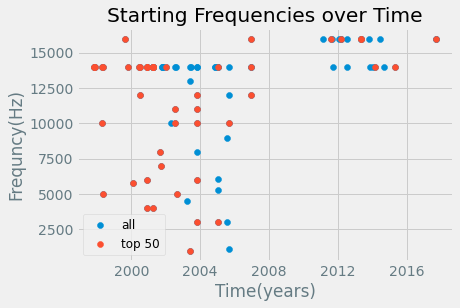

In [149]:
top50 = export.copy()
new = result[result["start_frequency"].notna()].copy()
new["start_datetime"] = pd.to_datetime(new["start_datetime"])
new["start_frequency"] = new["start_frequency"].astype(float)

top50["start_datetime"] = pd.to_datetime(top50["start_datetime"])
top50["start_frequency"] = top50["start_frequency"].astype(float)
plt.style.use('fivethirtyeight')
plt.scatter(new["start_datetime"], new["start_frequency"], label = "all")
plt.scatter(top50["start_datetime"], top50["start_frequency"], label = "top 50")
plt.title("Starting Frequencies over Time")

plt.legend(loc='best', fontsize=12)
plt.xlabel("Time(years)")
plt.ylabel("Frequncy(Hz)")

plt.show()